In [15]:
import os
import requests
import random
import numpy as np
import math
import matplotlib.pyplot as plt
from sklearn import linear_model, model_selection

import torch
from torch import nn
from torch.nn.utils import prune
from torch import optim
from torch.utils.data import DataLoader, ConcatDataset, TensorDataset

import torchvision
from torchvision import transforms
from torchvision.utils import make_grid
from torchvision.models import resnet18

import ssd as ssd

DEVICE = "cuda" if torch.cuda.is_available() else "cpu"
print("Running on device:", DEVICE.upper())

# manual random seed is used for dataset partitioning
# to ensure reproducible results across runs
RNG = torch.Generator().manual_seed(42)

Running on device: CUDA


In [2]:
import ssl

# Create an unverified SSL context
ssl._create_default_https_context = ssl._create_unverified_context

In [3]:
# download and pre-process CIFAR10
normalize = transforms.Compose(
    [
        transforms.ToTensor(),
        transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010)),
    ]
)

train_set = torchvision.datasets.CIFAR10(
    root="../example notebooks/data", train=True, download=False, transform=normalize
)
train_loader = DataLoader(train_set, batch_size=128, shuffle=True, num_workers=2)

# we split held out data into test and validation set
held_out = torchvision.datasets.CIFAR10(
    root="../example notebooks/data", train=False, download=False, transform=normalize
)
test_set, val_set = torch.utils.data.random_split(held_out, [0.5, 0.5], generator=RNG)
test_loader = DataLoader(test_set, batch_size=128, shuffle=False, num_workers=2)
val_loader = DataLoader(val_set, batch_size=128, shuffle=False, num_workers=2)

# download the forget and retain index split
local_path = "../example notebooks/forget_idx.npy"
# if not os.path.exists(local_path):
#     response = requests.get(
#         "https://storage.googleapis.com/unlearning-challenge/" + local_path
#     )
#     open(local_path, "wb").write(response.content)
forget_idx = np.load(local_path)

# construct indices of retain from those of the forget set
forget_mask = np.zeros(len(train_set.targets), dtype=bool)
forget_mask[forget_idx] = True
retain_idx = np.arange(forget_mask.size)[~forget_mask]

# split train set into a forget and a retain set
forget_set = torch.utils.data.Subset(train_set, forget_idx)
retain_set = torch.utils.data.Subset(train_set, retain_idx)

forget_loader = torch.utils.data.DataLoader(
    forget_set, batch_size=128, shuffle=True, num_workers=2
)
retain_loader = torch.utils.data.DataLoader(
    retain_set, batch_size=128, shuffle=True, num_workers=2, generator=RNG
)

We'll now download the weights of the model trained in CIFAR-10 and load them in a Pytorch model. This model has been trained using SGD with a learning rate of 0.1, momentum of 0.9 and weight decay of 5e-4. It was also trained using data augmentation. In particular, the transforms used to the data were:

```python
transform_train = transforms.Compose([
    transforms.RandomCrop(32, padding=4),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010)),
])
```


In [4]:
# load pre-trained weights
local_path = "../example notebooks/weights/weights_resnet18_cifar10.pth"
if not os.path.exists(local_path):
    response = requests.get(
        "https://storage.googleapis.com/unlearning-challenge/weights_resnet18_cifar10.pth"
    )
    open(local_path, "wb").write(response.content)

weights_pretrained = torch.load(local_path, map_location=DEVICE) #43Mbs

# load model with pre-trained weights
model = resnet18(weights=None, num_classes=10)
model.load_state_dict(weights_pretrained)
model.to(DEVICE)
model.eval();

Let us show some of the training images, just for fun.

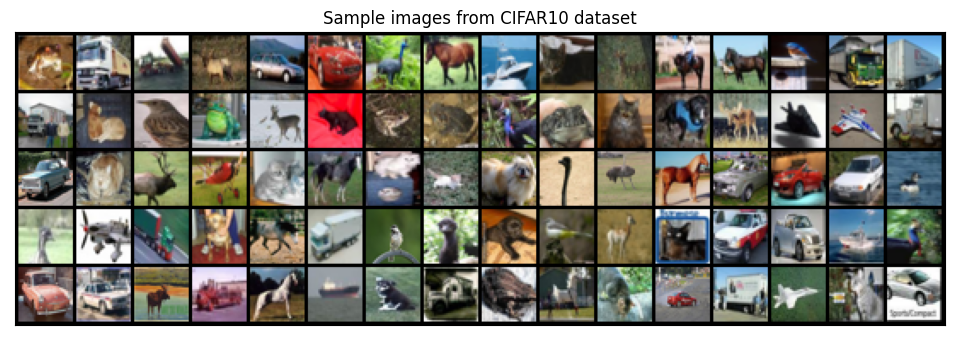

In [5]:
# a temporary data loader without normalization, just to show the images
tmp_dl = DataLoader(
    torchvision.datasets.CIFAR10(
        root="../example notebooks/data", train=True, download=False, transform=transforms.ToTensor()
    ),
    batch_size=16 * 5,
    shuffle=False,
)
images, labels = next(iter(tmp_dl))

fig, ax = plt.subplots(figsize=(12, 6))
plt.title("Sample images from CIFAR10 dataset")
ax.set_xticks([])
ax.set_yticks([])
ax.imshow(make_grid(images, nrow=16).permute(1, 2, 0))
plt.show()

We'll now compute the model's accuracy on the train and test set.


In [6]:
def accuracy(net, loader):
    """Return accuracy on a dataset given by the data loader."""
    correct = 0
    total = 0
    for inputs, targets in loader:
        inputs, targets = inputs.to(DEVICE), targets.to(DEVICE)
        outputs = net(inputs)
        _, predicted = outputs.max(1)
        total += targets.size(0)
        correct += predicted.eq(targets).sum().item()
    return correct / total


print(f"Train set accuracy: {100.0 * accuracy(model, train_loader):0.1f}%")
print(f"Test set accuracy: {100.0 * accuracy(model, test_loader):0.1f}%")

Train set accuracy: 99.5%
Test set accuracy: 88.3%


# 🎯 Unlearning Algorithm

In [7]:
# from torch.nn import functional as F

# def JSDiv(p, q):
#     m = (p + q) / 2
#     return 0.5 * F.kl_div(torch.log(p), m) + 0.5 * F.kl_div(torch.log(q), m)


# # ZRF/UnLearningScore https://arxiv.org/abs/2205.08096
# def UnLearningScore(tmodel, gold_model, forget_dl, batch_size, device):
#     model_preds = []
#     gold_model_preds = []
#     with torch.no_grad():
#         for batch in forget_dl:
#             x, y, cy = batch
#             x = x.to(device)
#             model_output = tmodel(x)
#             gold_model_output = gold_model(x)
#             model_preds.append(F.softmax(model_output, dim=1).detach().cpu())
#             gold_model_preds.append(F.softmax(gold_model_output, dim=1).detach().cpu())

#     model_preds = torch.cat(model_preds, axis=0)
#     gold_model_preds = torch.cat(gold_model_preds, axis=0)
#     return 1 - JSDiv(model_preds, gold_model_preds)

In [8]:
def unlearning(net, retain, forget, validation, alpha, lambda_):

    optimizer = torch.optim.SGD(net.parameters(), lr=0.001, weight_decay=0)

    # ALPHA [0.1, 100]
    # LAMBDA [0.1, 5]

    # alpha = 1 # alpha in the paper
    # lambda_ = 1 # lambda in the paper
    selection_weighting = 10 * alpha

    parameters = {
        "lower_bound": 1,
        "exponent": 1,
        "magnitude_diff": None,
        "min_layer": -1,
        "max_layer": -1,
        "forget_threshold": 1,
        "dampening_constant": lambda_,
        "selection_weighting": selection_weighting,
    }

    full_train_dl = DataLoader(
    ConcatDataset((retain.dataset, forget.dataset)),
    batch_size=128,
    )

    pdr = ssd.ParameterPerturber(net, optimizer, DEVICE, parameters)

    net = net.eval()

    sample_importances = pdr.calc_gradient_importance(forget)
    original_importances = pdr.calc_gradient_importance(full_train_dl)
    pdr.modify_weight_for_gradient(original_importances, sample_importances)

    # net.eval()
    return net

In [9]:
parameters = {
        "lower_bound": 1,
        "exponent": 1,
        "magnitude_diff": None,
        "min_layer": -1,
        "max_layer": -1,
        "forget_threshold": 1,
        "dampening_constant": 0.65,
        "selection_weighting": 10,
        "alpha": 5, #multiplier to retain importance
        "beta": 0.75, #decay of forget importance
        "theta": 1 #decay of weights
    }

# load model with pre-trained weights
ft_model = resnet18(weights=None, num_classes=10)
ft_model.load_state_dict(weights_pretrained)
ft_model.to(DEVICE)
ft_model.eval()

pdr = ssd.ParameterPerturber(ft_model, torch.optim.SGD(ft_model.parameters(), lr=0.001, weight_decay=0), DEVICE, parameters)

In [10]:
sample_importances = pdr.calc_gradient_importance(forget_loader, debug=False)

full_train_dl = DataLoader(
ConcatDataset((retain_loader.dataset, forget_loader.dataset)),
batch_size=128,
)

original_importances = pdr.calc_gradient_importance(full_train_dl)

pdr.modify_weight_neuron_level(original_importances, sample_importances)

print(f"Retain set accuracy: {100.0 * accuracy(ft_model, retain_loader):0.1f}%")
print(f"Forget set accuracy: {100.0 * accuracy(ft_model, forget_loader):0.1f}%")
print(f"Test set accuracy: {100.0 * accuracy(ft_model, test_loader):0.1f}%")

Retain set accuracy: 99.5%
Forget set accuracy: 99.3%
Test set accuracy: 88.4%


In [11]:
def SSD(model):
    pdr = ssd.ParameterPerturber(model, torch.optim.SGD(model.parameters(), lr=0.001, weight_decay=0), DEVICE, parameters)
    sample_importances = pdr.calc_gradient_importance(forget_loader, debug=False)
    original_importances = pdr.calc_gradient_importance(retain_loader)
    pdr.modify_weight_neuron_level_new(original_importances, sample_importances)

In [12]:
# print(f"Retain set accuracy: {100.0 * accuracy(pdr.model, retain_loader):0.1f}%")
# print(f"Forget set accuracy: {100.0 * accuracy(pdr.model, forget_loader):0.1f}%")
# print(f"Test set accuracy: {100.0 * accuracy(pdr.model, test_loader):0.1f}%")

## Other approaches:

### Prune network

In [13]:
def global_unstructure_prune(model, pruning_amount=0.2):

    parameters_to_prune = []
    for name, module in model.named_modules():
        if isinstance(module, torch.nn.Conv2d) or isinstance(module, torch.nn.Linear):
            parameters_to_prune.append((module, 'weight'))

    # Global pruning
    prune.global_unstructured(
        parameters_to_prune,
        pruning_method=prune.L1Unstructured,
        amount=pruning_amount
    )

    # Make the pruning permanent
    for module, param_name in parameters_to_prune:
        prune.remove(module, param_name)

In [14]:
# Function to update learning rate
def adjust_learning_rate(optimizer, current_batch, total_batches, initial_lr):
    """Sets the learning rate for warmup over total_batches"""
    lr = initial_lr * (current_batch / total_batches)
    for param_group in optimizer.param_groups:
        param_group['lr'] = lr

In [22]:
def unlearning(net, retain, forget, validation):

    # Apply pruning
    # pct = 0.9
    # global_unstructure_prune(net, pct)

    epochs = 1

    # LR warmup - Forget
    # total_samples = len(forget.dataset)
    # batch_size = forget.batch_size
    # batches_per_epoch  = math.ceil(total_samples / batch_size)
    # initial_lr_forget = 0.01/2
    # warmup_batches_forget = math.ceil(0.4*batches_per_epoch)

    # LR warmup - Retain
    total_samples = len(retain.dataset)
    batch_size = retain.batch_size
    batches_per_epoch  = math.ceil(total_samples / batch_size)
    initial_lr = 0.01/2
    warmup_batches = math.ceil(0.8*batches_per_epoch)

    # Split retain set  
    # retain_set1, retain_set2 = torch.utils.data.random_split(retain.dataset, [0.5, 0.5], generator=RNG)
    # retain1 = DataLoader(retain_set1, batch_size=64, shuffle=True, num_workers=2)
    # retain2 = DataLoader(retain_set2, batch_size=64, shuffle=True, num_workers=2)

    # Training parameters
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.SGD(net.parameters(), lr=initial_lr, momentum=0.9, weight_decay=5e-4)
    # optimizer_forget = optimizer_retain
    # optimizer_forget = optim.SGD(net.parameters(), lr=initial_lr_forget, momentum=0.9, weight_decay=5e-4)

    # Start training
    net.train()
    for _ in range(epochs):

        # Initialize iterators at the beginning of each epoch
        current_batch = 0
        iter_retain = iter(retain)
        # iter_retain1 = iter(retain1)
        # iter_retain2 = iter(retain2)
        iter_forget = iter(forget)


        '''
        Selective Impair
        '''
        for _ in range(batches_per_epoch*2):
            weights = torch.tensor([80, 20], dtype=torch.float32)

            # Initialize flag for depleted iterator
            one_depleted = False

            # Randomly choose a loader based on weights
            chosen_loader_idx = torch.multinomial(weights, 1).item()
            if current_batch < math.ceil(0.1*batches_per_epoch):
                batch = next(iter_retain)
                multiplier = 1
                current_batch += 1
            else:
                if chosen_loader_idx == 0:  # corresponds to retain_loader
                    try:
                        batch = next(iter_retain)
                        multiplier = 1
                        current_batch += 1
                    except StopIteration:
                        one_depleted = True
                        continue  # Skip to the next iteration
                        
                else:  # corresponds to forget_loader
                    try:
                        batch = next(iter_forget)
                        multiplier = -1
                        current_batch += 1
                    except StopIteration:
                        one_depleted = True
                        continue  # Skip to the next iteration

            # print(multiplier)
            inputs, targets = batch                
            inputs, targets = inputs.to(DEVICE), targets.to(DEVICE)
            # current_batch += 1

            # Warm-up for the first 'warmup_batches' batches
            if current_batch <= warmup_batches:
                adjust_learning_rate(optimizer, current_batch, warmup_batches, initial_lr)

            net.train()
            optimizer.zero_grad()
            outputs = net(inputs)
            loss = criterion(outputs, targets)
            loss = loss*multiplier
            loss.backward()
            optimizer.step()

        net.eval()
        # print(f"Retain set accuracy: {100.0 * accuracy(net, retain):0.1f}%")
        # print(f"Forget set accuracy: {100.0 * accuracy(net, forget):0.1f}%")
        # print(f"Test set accuracy: {100.0 * accuracy(net, test_loader):0.1f}%")


        '''
        Selective Repair
        '''
        # net.train()
        # multiplier = 1
        # warmup_batches = warmup_batches_retain
        # optimizer = optimizer_retain
        # initial_lr = initial_lr_retain
        # current_batch_retain += 1
        # current_batch = current_batch_retain
        
        # for _ in range(batches_per_epoch//2):
        #     # print(_)
        #     batch = next(iter_retain2)
        #     inputs, targets = batch
        #     inputs, targets = inputs.to(DEVICE), targets.to(DEVICE)

        #     current_batch += 1

        #     # Warm-up for the first 'warmup_batches' batches
        #     if current_batch <= warmup_batches:
        #         adjust_learning_rate(optimizer, current_batch, warmup_batches, initial_lr)

        #     optimizer.zero_grad()
        #     outputs = net(inputs)
        #     loss = criterion(outputs, targets)
        #     loss.backward()
        #     optimizer.step()
        # scheduler.step()


    net.eval()
    return net

In [65]:
from importlib import reload
reload(ssd)

<module 'ssd' from 'c:\\Users\\luis.pinto1\\Documents\\GitLab\\machine-unlearning\\SSD\\ssd.py'>

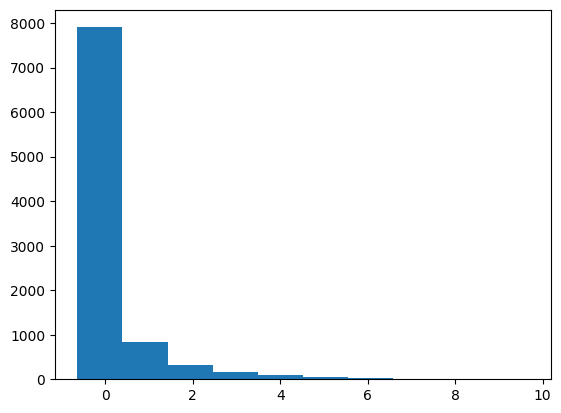

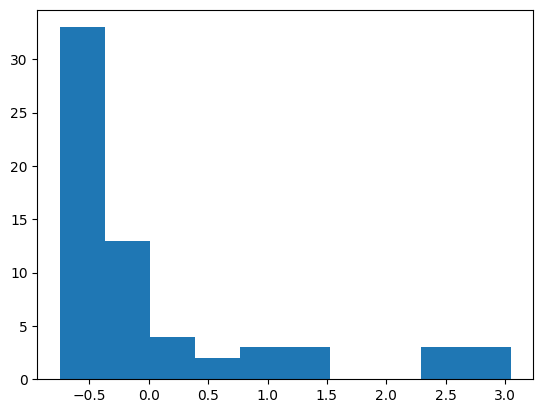

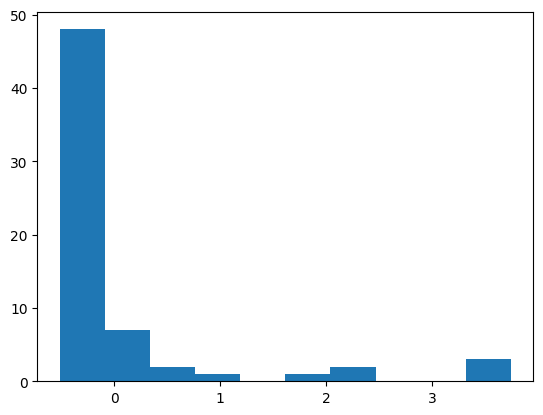

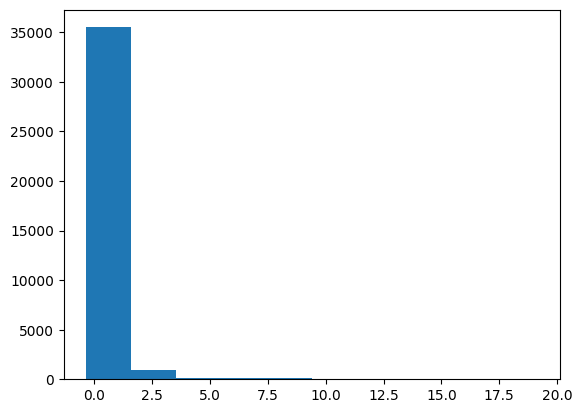

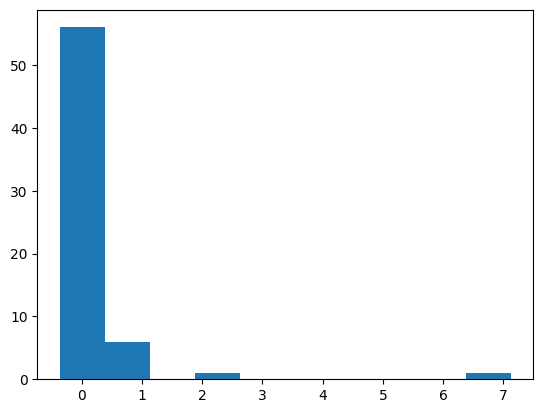

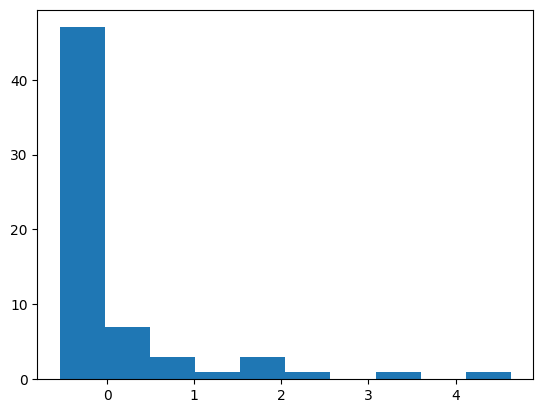

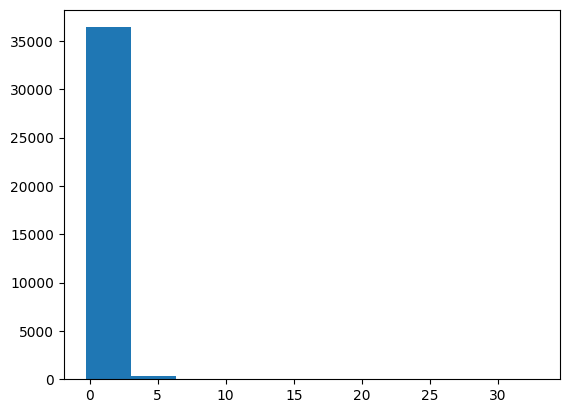

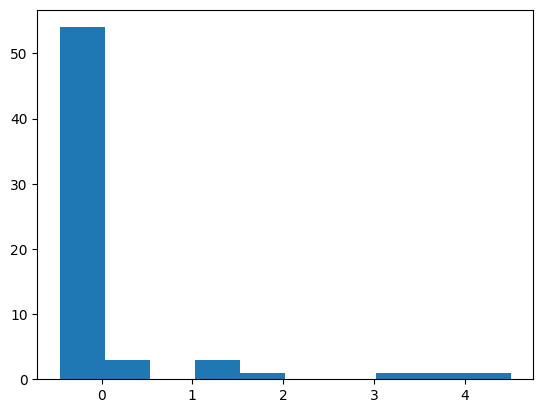

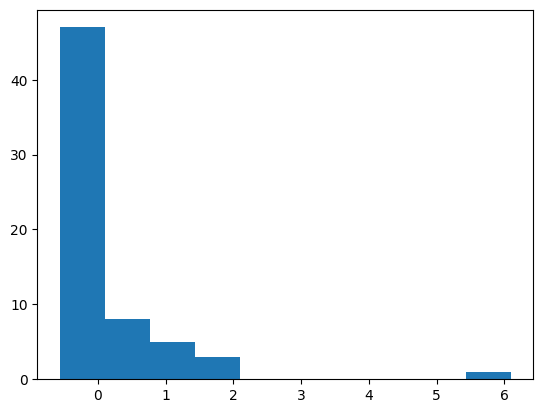

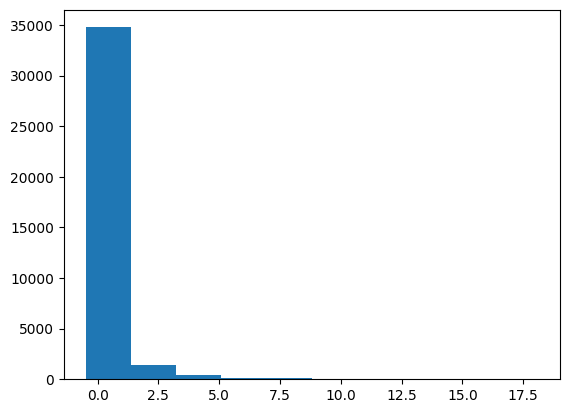

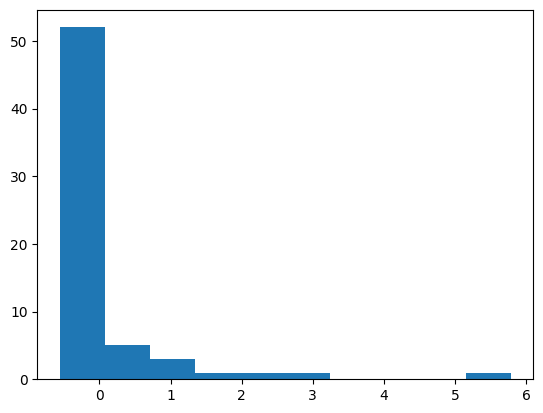

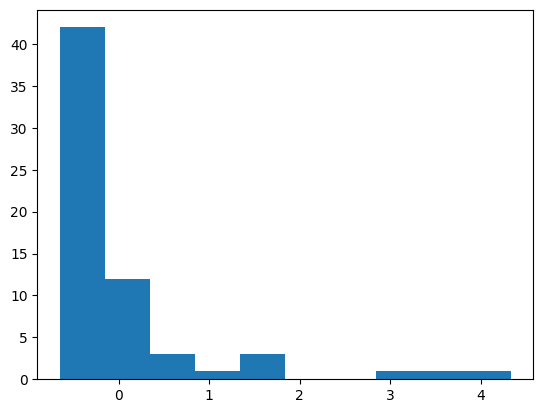

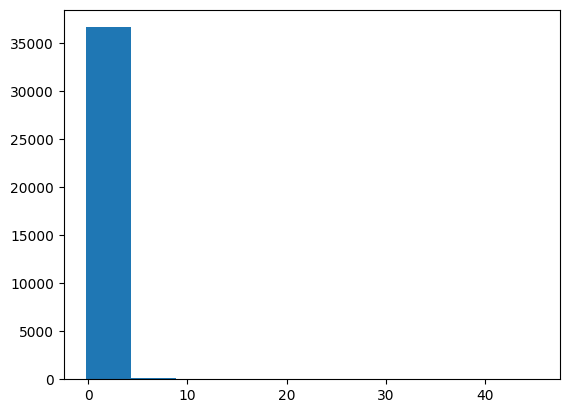

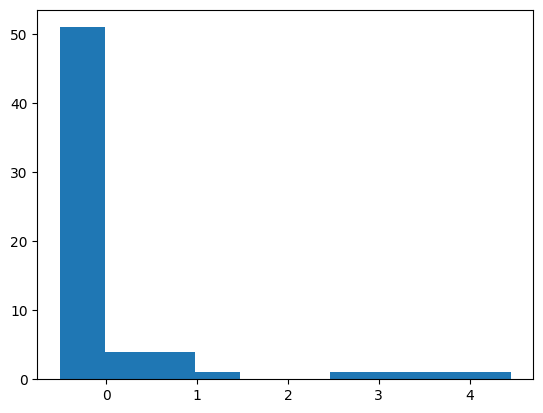

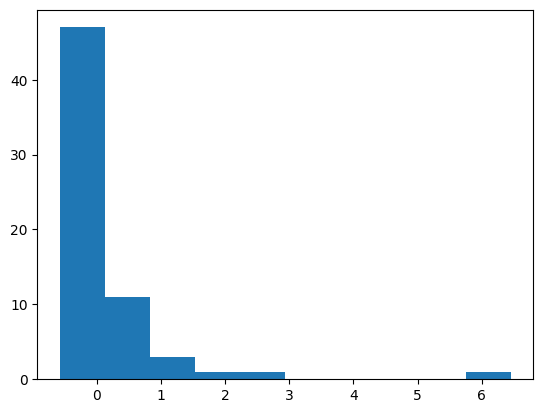

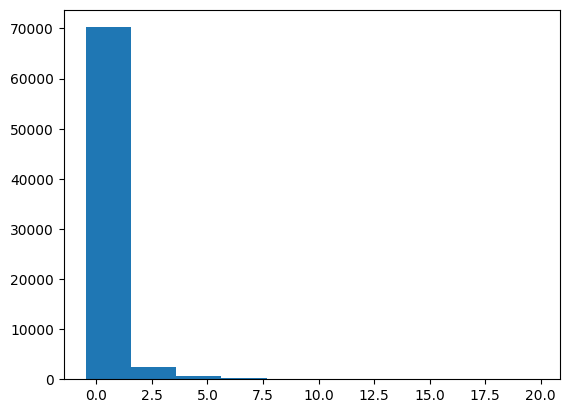

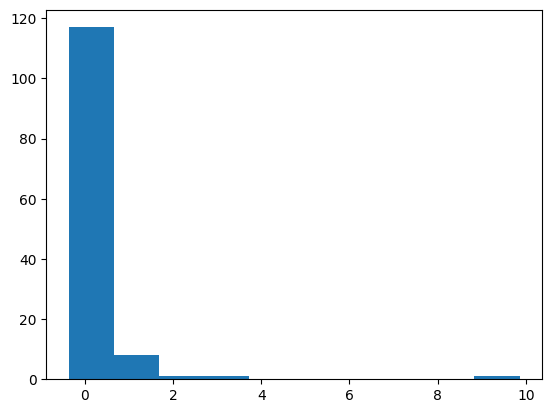

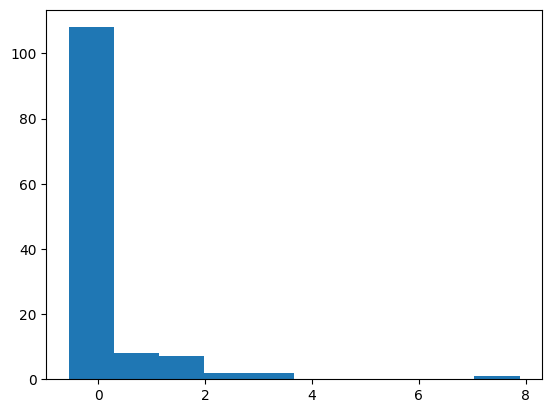

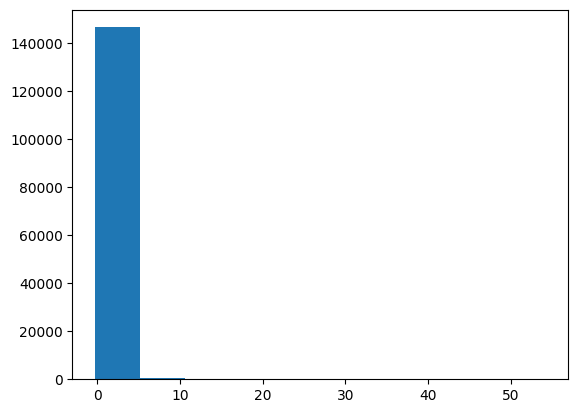

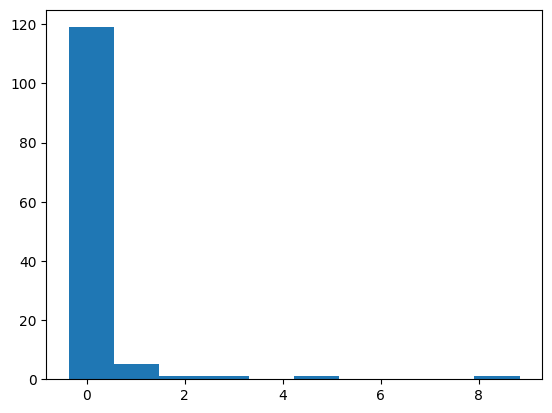

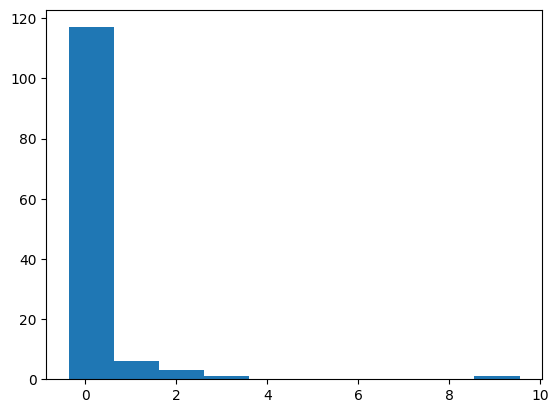

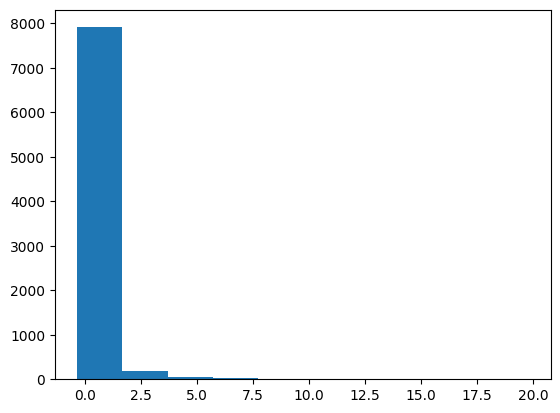

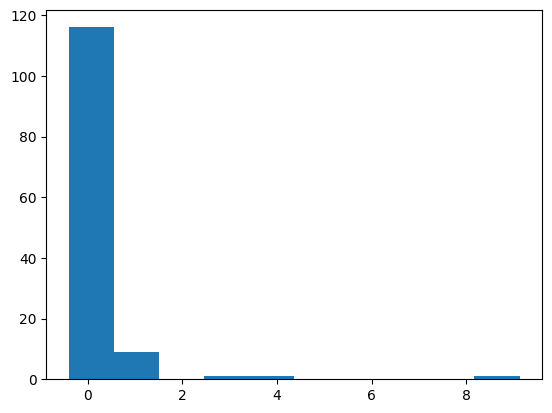

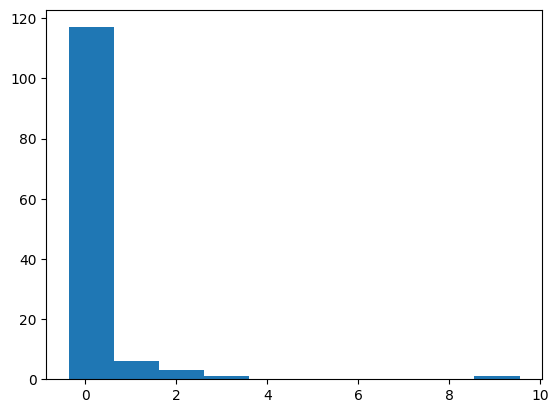

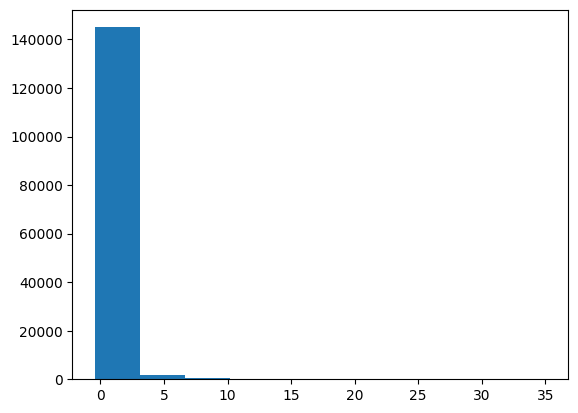

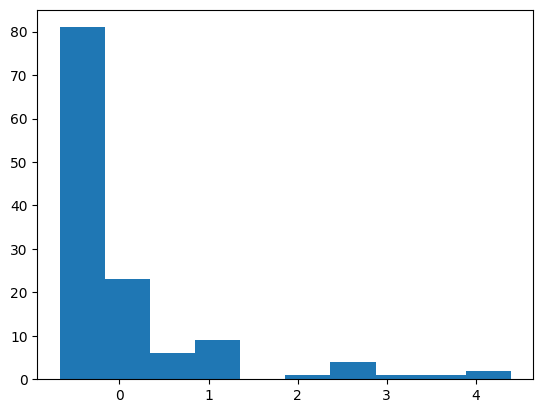

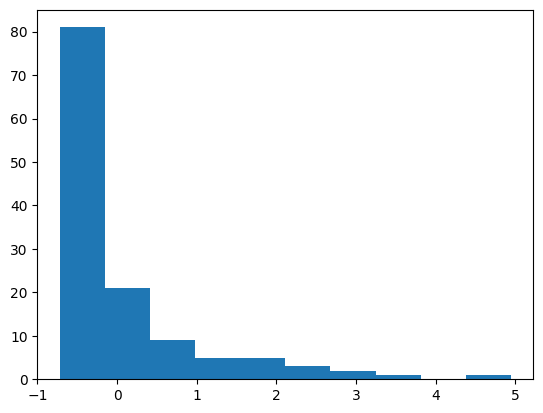

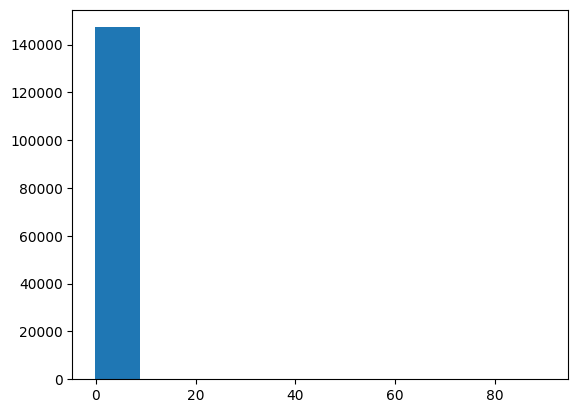

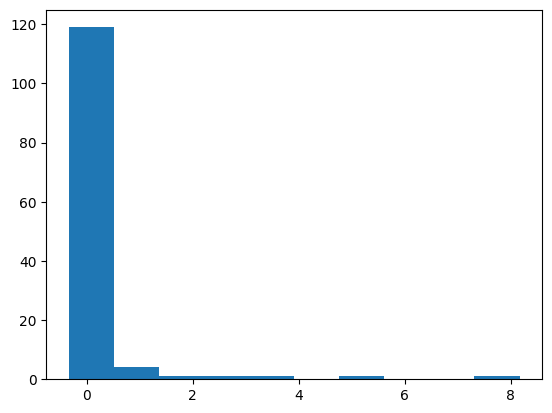

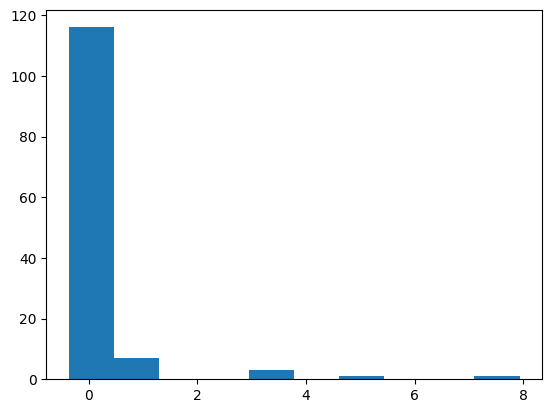

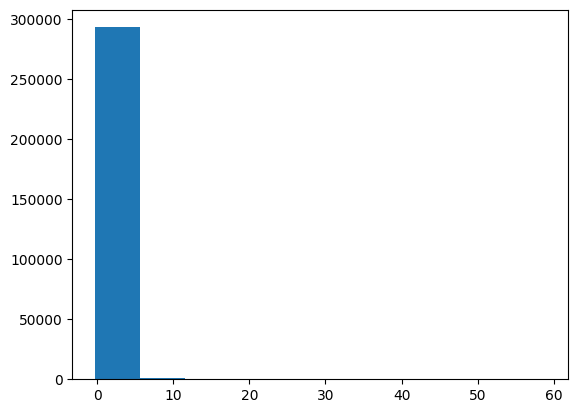

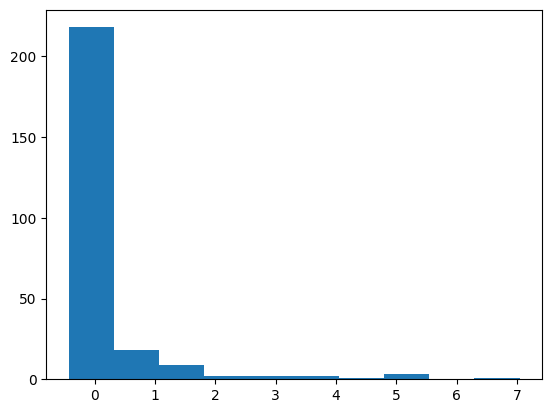

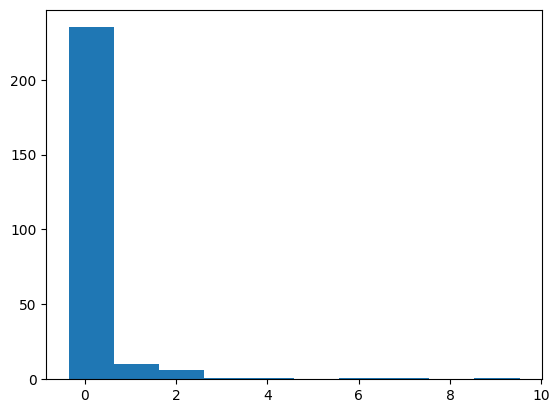

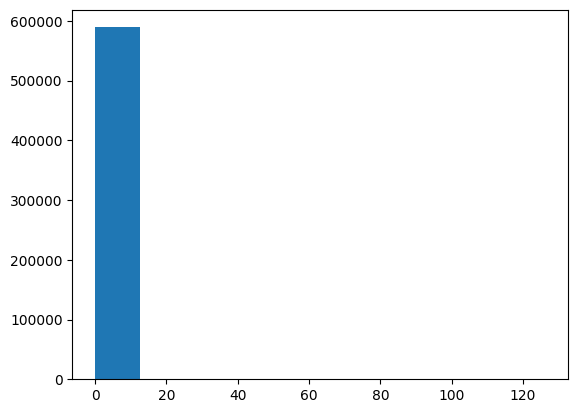

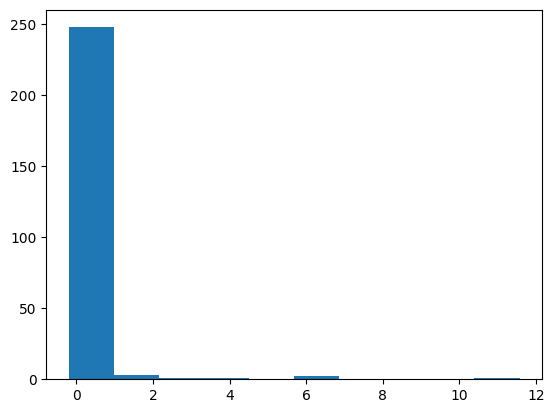

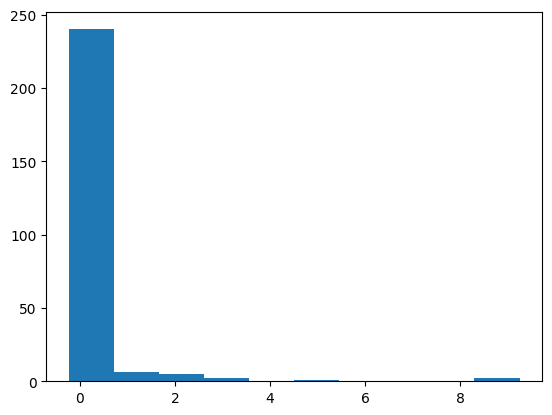

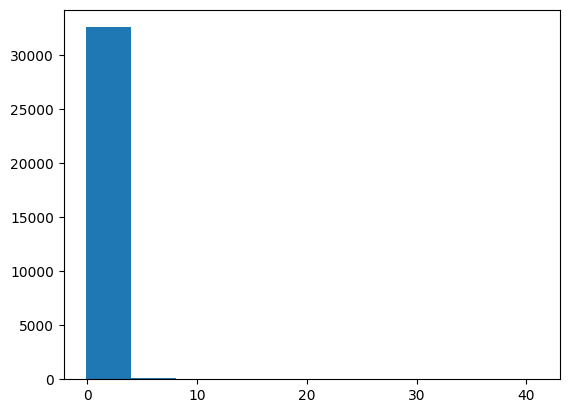

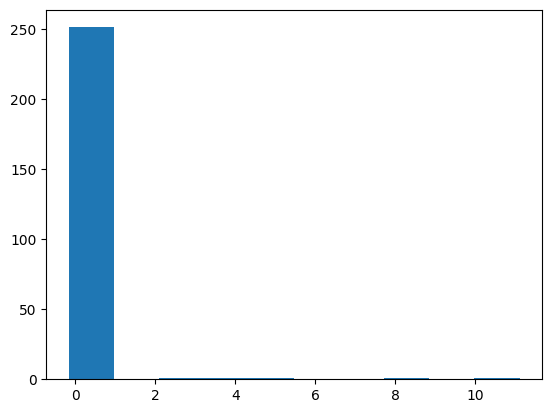

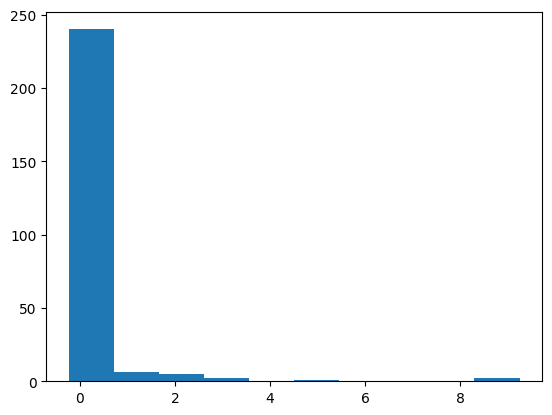

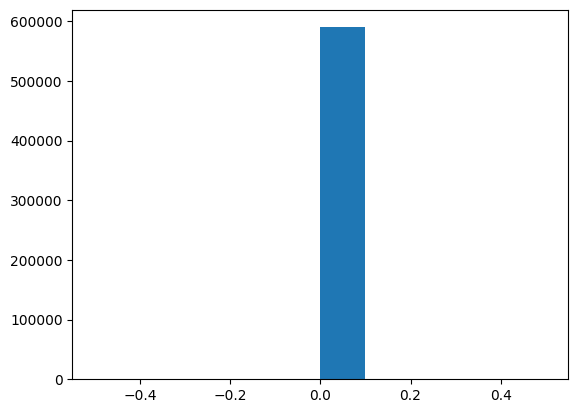

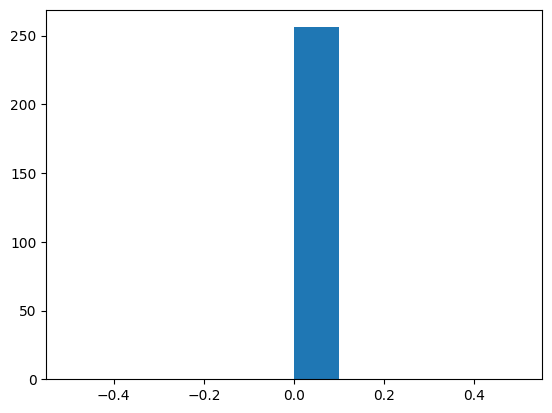

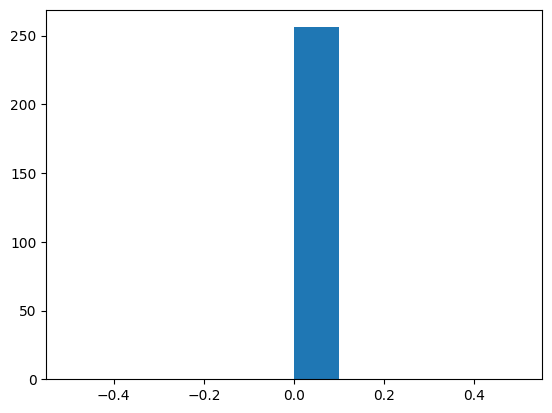

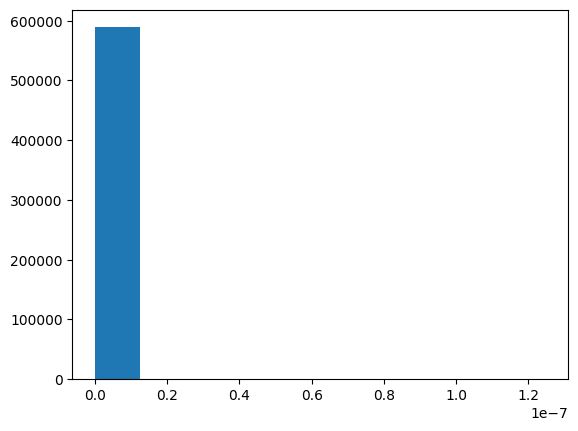

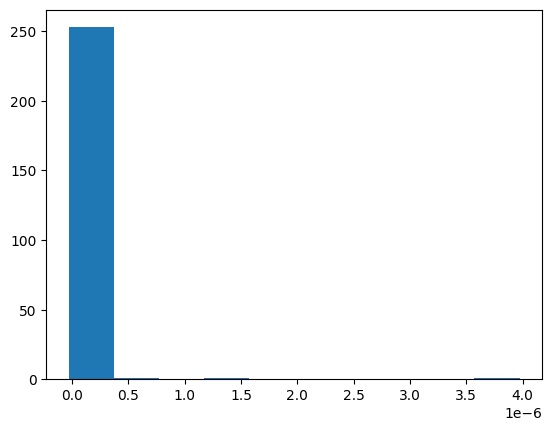

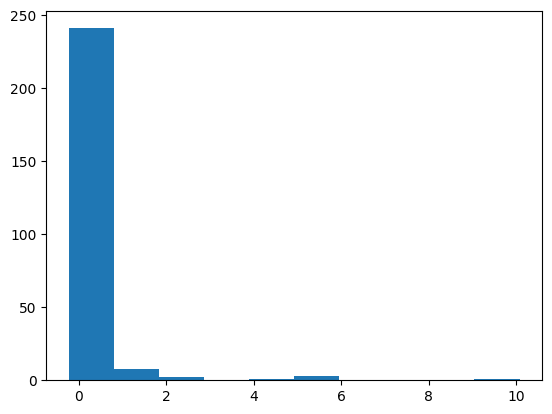

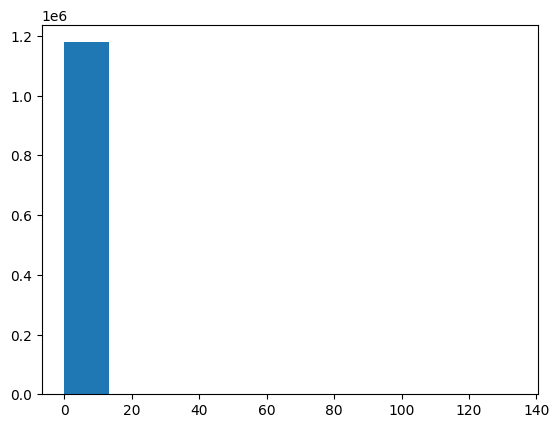

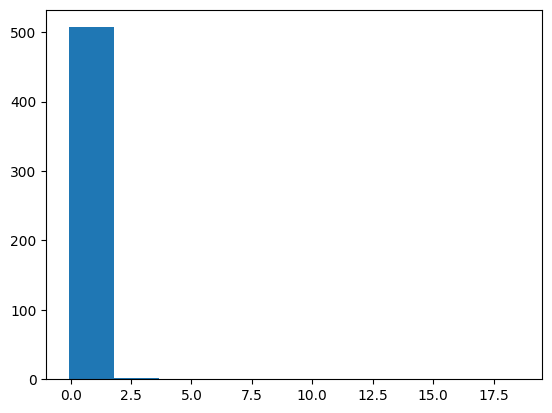

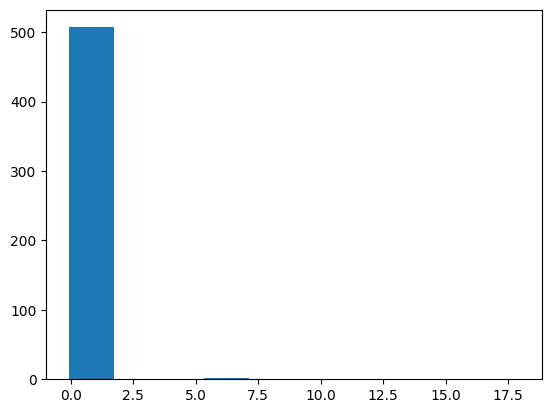

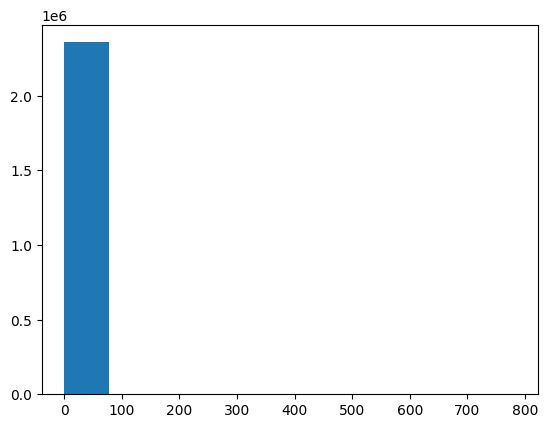

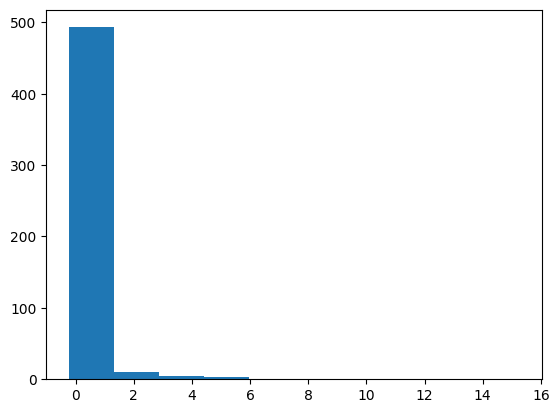

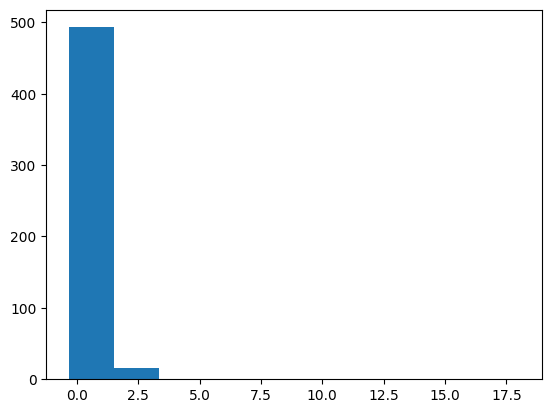

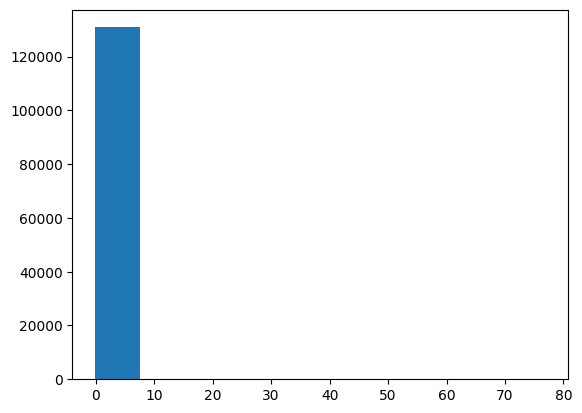

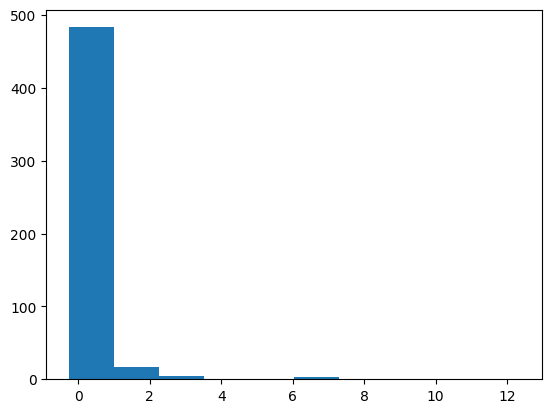

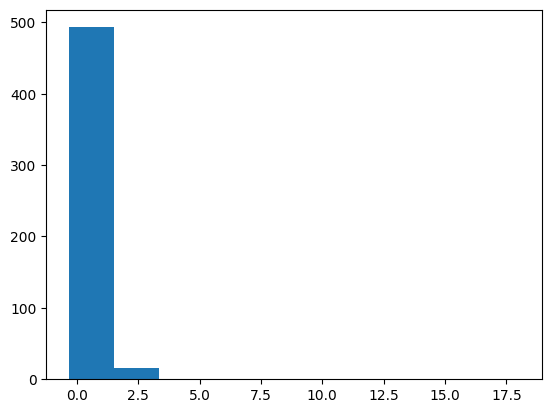

KeyboardInterrupt: 

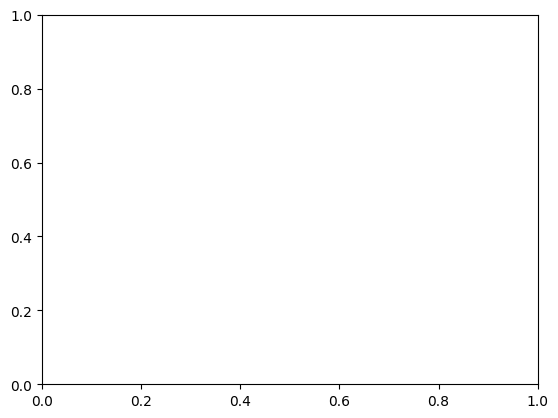

In [66]:
pcts = [0, 0.1, 0.2, 0.3, 0.5, 0.7, 0.9, 0.95]
ret_accs = []
forget_accs = []
test_accs = []

# ft_model = resnet18(weights=None, num_classes=10)
# ft_model.load_state_dict(weights_pretrained)
# ft_model.to(DEVICE)

parameters = {
        "lower_bound": 1,
        "exponent": 1,
        "magnitude_diff": None,
        "min_layer": -1,
        "max_layer": -1,
        "forget_threshold": 1,
        "dampening_constant": 1,
        "selection_weighting": 10,
        "alpha": 5, #multiplier to retain importance
        "beta": 0.75, #decay of forget importance
        "theta": 0.95 #decay of weights
    }

# ret_accs.append(100.0 * accuracy(ft_model, retain_loader))
# forget_accs.append(100.0 * accuracy(ft_model, forget_loader))
# test_accs.append(100.0 * accuracy(ft_model, test_loader))


for pct in [0.99]:
    if pct==0:
        continue
    ft_model = resnet18(weights=None, num_classes=10)
    ft_model.load_state_dict(weights_pretrained)
    ft_model.to(DEVICE)
    ft_model.eval()

    # Apply pruning
    global_unstructure_prune(ft_model, pct)

    # full_train_dl = DataLoader(
    # ConcatDataset((retain_loader.dataset, forget_loader.dataset)),
    # batch_size=128,
    # )

    pdr = ssd.ParameterPerturber(ft_model, torch.optim.SGD(ft_model.parameters(), lr=0.001, weight_decay=0), DEVICE, parameters)
    sample_importances = pdr.calc_gradient_importance(forget_loader, debug=False)
    original_importances = pdr.calc_gradient_importance(retain_loader)

    pdr.modify_weight_neuron_level_new(original_importances, sample_importances)

    print(100.0 * accuracy(ft_model, retain_loader))
    print(100.0 * accuracy(ft_model, forget_loader))
    print(100.0 * accuracy(ft_model, test_loader))



    ft_model = unlearning(ft_model, retain_loader, forget_loader, None)

    print(100.0 * accuracy(ft_model, retain_loader))
    print(100.0 * accuracy(ft_model, forget_loader))
    print(100.0 * accuracy(ft_model, test_loader))

In [ ]:
plt.plot(pcts, ret_accs, 'ko', label='Retain')
plt.plot(pcts, forget_accs, 'ro', label='Forget')
plt.plot(pcts, test_accs, 'bo', label='Test')
plt.ylabel('Accuracy')
plt.xlabel('Sparsity')
plt.show()

### Use occlusion instead of grad importance

In [ ]:
sample_importances = pdr.calc_occlusion_sensitivity(forget_loader)

full_train_dl = DataLoader(
ConcatDataset((retain_loader.dataset, forget_loader.dataset)),
batch_size=128,
)

original_importances = pdr.calc_occlusion_sensitivity(full_train_dl)

pdr.modify_weight_layer_level(original_importances, sample_importances)

print(f"Retain set accuracy: {100.0 * accuracy(model, retain_loader):0.1f}%")
print(f"Test set accuracy: {100.0 * accuracy(model, test_loader):0.1f}%")
print(f"Forget set accuracy: {100.0 * accuracy(model, forget_loader):0.1f}%")

Retain set accuracy: 99.5%
Test set accuracy: 88.3%
Forget set accuracy: 99.3%


In [ ]:
# model(x_batch.to(DEVICE))

In [ ]:
# ALPHA [0.1, 100]
# LAMBDA [0.1, 5]

for (alp, lam) in [(0.1, 10)]:
    print(f"Alpha = {alp}, Lambda = {lam}")
    
    ft_model = resnet18(weights=None, num_classes=10)
    ft_model.load_state_dict(weights_pretrained)
    ft_model.to(DEVICE)

    # preds = ft_model(x_batch.to(DEVICE))
    # _, targets = torch.topk(preds, 2, dim=1)
    # print(_)
    # for _ in range(5):
    ft_model = unlearning(ft_model, retain_loader, forget_loader, test_loader, alp, lam)
    # print(f"Forget set accuracy: {100.0 * accuracy(ft_model, forget_loader):0.4f}%")

    # print('aaaa')
    # preds = ft_model(x_batch.to(DEVICE))
    # _, targets = torch.topk(preds, 2, dim=1)
    # print(_)

    print(f"Retain set accuracy: {100.0 * accuracy(ft_model, retain_loader):0.4f}%")
    print(f"Test set accuracy: {100.0 * accuracy(ft_model, test_loader):0.4f}%")
    print(f"Forget set accuracy: {100.0 * accuracy(ft_model, forget_loader):0.4f}%")

# 🏅 Evaluation

In this section, we'll quantify the quality of the unlearning algorithm through a simple membership inference attack (MIA). We provide this simple MIA for convenience so that participants can quickly obtain a metric for their unlearning algorithm, but submissions will be scored using a different method.

This MIA consists of a [logistic regression model](https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression) that predicts whether the model was trained on a particular sample from that sample's loss. To get an idea on the difficulty of this problem, we first plot below a histogram of the losses of the pre-trained model on the train and test set

In [31]:
def compute_losses(net, loader):
    """Auxiliary function to compute per-sample losses"""

    criterion = nn.CrossEntropyLoss(reduction="none")
    all_losses = []

    for inputs, targets in loader:
        inputs, targets = inputs.to(DEVICE), targets.to(DEVICE)

        logits = net(inputs)
        losses = criterion(logits, targets).numpy(force=True)
        for l in losses:
            all_losses.append(l)

    return np.array(all_losses)


train_losses = compute_losses(model, train_loader)
test_losses = compute_losses(model, test_loader)

In [32]:
def simple_mia(sample_loss, members, n_splits=10, random_state=0):
    """Computes cross-validation score of a membership inference attack.

    Args:
      sample_loss : array_like of shape (n,).
        objective function evaluated on n samples.
      members : array_like of shape (n,),
        whether a sample was used for training.
      n_splits: int
        number of splits to use in the cross-validation.
    Returns:
      scores : array_like of size (n_splits,)
    """

    unique_members = np.unique(members)
    if not np.all(unique_members == np.array([0, 1])):
        raise ValueError("members should only have 0 and 1s")

    attack_model = linear_model.LogisticRegression()
    cv = model_selection.StratifiedShuffleSplit(
        n_splits=n_splits, random_state=random_state
    )
    return model_selection.cross_val_score(
        attack_model, sample_loss, members, cv=cv, scoring="accuracy"
    )

In [33]:
forget_losses = compute_losses(model, forget_loader)

# Since we have more forget losses than test losses, sub-sample them, to have a class-balanced dataset.
np.random.shuffle(forget_losses)
forget_losses = forget_losses[: len(test_losses)]

samples_mia = np.concatenate((test_losses, forget_losses)).reshape((-1, 1))
labels_mia = [0] * len(test_losses) + [1] * len(forget_losses)

mia_scores = simple_mia(samples_mia, labels_mia)

print(
    f"The MIA has an accuracy of {mia_scores.mean():.3f} on forgotten vs unseen images"
)

The MIA has an accuracy of 0.578 on forgotten vs unseen images


In [53]:
ft_forget_losses = compute_losses(ft_model, forget_loader)
ft_test_losses = compute_losses(ft_model, test_loader)

# make sure we have a balanced dataset for the MIA
assert len(ft_test_losses) == len(ft_forget_losses)

ft_samples_mia = np.concatenate((ft_test_losses, ft_forget_losses)).reshape((-1, 1))
labels_mia = [0] * len(ft_test_losses) + [1] * len(ft_forget_losses)

In [54]:
ft_mia_scores = simple_mia(ft_samples_mia, labels_mia)

print(
    f"The MIA has an accuracy of {ft_mia_scores.mean():.3f} on forgotten vs unseen images"
)

The MIA has an accuracy of 0.508 on forgotten vs unseen images


From the score above, the MIA is indeed less accurate on the unlearned model than on the original model, as expected. Finally, we'll plot the histogram of losses of the unlearned model on the train and test set. From the below figure, we can observe that the distributions of forget and test losses are more similar under the unlearned model compared to the original model, as expected.

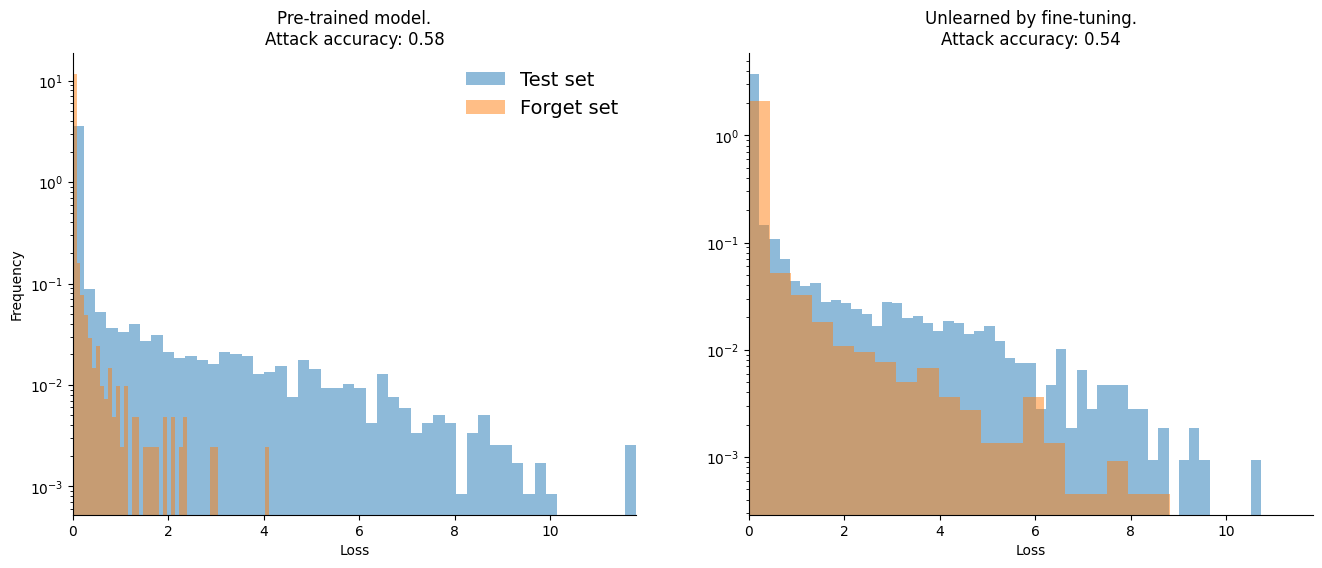

In [36]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 6))

ax1.set_title(f"Pre-trained model.\nAttack accuracy: {mia_scores.mean():0.2f}")
ax1.hist(test_losses, density=True, alpha=0.5, bins=50, label="Test set")
ax1.hist(forget_losses, density=True, alpha=0.5, bins=50, label="Forget set")

ax2.set_title(
    f"Unlearned by fine-tuning.\nAttack accuracy: {ft_mia_scores.mean():0.2f}"
)
ax2.hist(ft_test_losses, density=True, alpha=0.5, bins=50, label="Test set")
ax2.hist(ft_forget_losses, density=True, alpha=0.5, bins=50, label="Forget set")

ax1.set_xlabel("Loss")
ax2.set_xlabel("Loss")
ax1.set_ylabel("Frequency")
ax1.set_yscale("log")
ax2.set_yscale("log")
ax1.set_xlim((0, np.max(test_losses)))
ax2.set_xlim((0, np.max(test_losses)))
for ax in (ax1, ax2):
    ax.spines["top"].set_visible(False)
    ax.spines["right"].set_visible(False)
ax1.legend(frameon=False, fontsize=14)
plt.show()

## Comparison with a re-trained model

One might ask, how good are the scores above? What is the best score? Since our goal is to approximate the model that has been trained only on the retain set, we'll consider that the gold standard is the score achieved by this model. Intuitively, we expect the MIA accuracy to be around 0.5, since for such a model, both the forget and test set are unseen samples from the same distribution. However, a number of factors such as distribution shift or class imbalance can make this number vary.

We'll now compute this score. We'll first download the weights for a model trained exclusively on the retain set and then compute the accuracy of the simple MIA.

In [ ]:
# download weights of a model trained exclusively on the retain set
local_path = "weights/retrain_weights_resnet18_cifar10.pth"
if not os.path.exists(local_path):
    response = requests.get(
        "https://storage.googleapis.com/unlearning-challenge/retrain_weights_resnet18_cifar10.pth"
    )
    open(local_path, "wb").write(response.content)

weights_pretrained = torch.load(local_path, map_location=DEVICE)

# load model with pre-trained weights
rt_model = resnet18(weights=None, num_classes=10)
rt_model.load_state_dict(weights_pretrained)
rt_model.to(DEVICE)
rt_model.eval()

# print its accuracy on retain and forget set
print(f"Retain set accuracy: {100.0 * accuracy(rt_model, retain_loader):0.1f}%")
print(f"Forget set accuracy: {100.0 * accuracy(rt_model, forget_loader):0.1f}%")

As expected, the model trained exclusively on the retain set has a higher accuracy on the retain set than on the forget set (whose accuracy is similar than on the test set)

In [ ]:
rt_test_losses = compute_losses(rt_model, test_loader)
rt_forget_losses = compute_losses(rt_model, forget_loader)

rt_samples_mia = np.concatenate((rt_test_losses, rt_forget_losses)).reshape((-1, 1))
labels_mia = [0] * len(rt_test_losses) + [1] * len(rt_forget_losses)

In [ ]:
rt_mia_scores = simple_mia(rt_samples_mia, labels_mia)

print(
    f"The MIA has an accuracy of {rt_mia_scores.mean():.3f} on forgotten vs unseen images"
)

As we expect, the accuracy of the MIA attack is roughly 0.5. Finally, as we've done before, let's compare the histograms of this ideal algorithm (re-trained model) vs the model obtain from

In [ ]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 6))

ax1.set_title(f"Re-trained model.\nAttack accuracy: {rt_mia_scores.mean():0.2f}")
ax1.hist(rt_test_losses, density=True, alpha=0.5, bins=50, label="Test set")
ax1.hist(rt_forget_losses, density=True, alpha=0.5, bins=50, label="Forget set")

ax2.set_title(
    f"Unlearned by fine-tuning.\nAttack accuracy: {ft_mia_scores.mean():0.2f}"
)
ax2.hist(ft_test_losses, density=True, alpha=0.5, bins=50, label="Test set")
ax2.hist(ft_forget_losses, density=True, alpha=0.5, bins=50, label="Forget set")

ax1.set_xlabel("Loss")
ax2.set_xlabel("Loss")
ax1.set_ylabel("Frequency")
ax1.set_yscale("log")
ax2.set_yscale("log")
ax1.set_xlim((0, np.max(test_losses)))
ax2.set_xlim((0, np.max(test_losses)))
for ax in (ax1, ax2):
    ax.spines["top"].set_visible(False)
    ax.spines["right"].set_visible(False)
ax1.legend(frameon=False, fontsize=14)
plt.show()